## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from neural_networks.seg_reg_net import SegRegNet
from neural_networks.net_utils import predict_density_maps_and_get_counts
from utils.data.data_generator import DataGenerator
from utils.evaluation.evaluation import evaluation_results_as_dict
from utils.evaluation.evaluation import evaluation_results_as_df
from utils.input_output.io import load_images_and_density_maps
from utils.input_output.io import read_json, write_json
from utils.input_output.io import load_gt_counts
from utils.visualization.vis import plot_some_predictions
from utils.visualization.vis import plot_gt_vs_pred_counts, plot_seg_reg_maps

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

### Select the checkpoint file that you want to test/evaluate

In [4]:
checkpoint_filenames = sorted(os.listdir(config.CHECKPOINTS_PATH))
print(checkpoint_filenames)

['best_model.hdf5', 'model.01-0.011.hdf5', 'model.02-0.010.hdf5', 'model.03-0.010.hdf5']


In [5]:
selected_checkpoint_filename = checkpoint_filenames[2]
print(f'selected checkpoint_filename: {selected_checkpoint_filename}')

selected checkpoint_filename: model.02-0.010.hdf5


In [6]:
epoch = selected_checkpoint_filename.split('.')[1].split('-')[0]
print('epoch:', epoch)

epoch: 02


In [7]:
# Set epoch and val loss
CHECKPOINT_FILENAME = f'{config.CHECKPOINTS_PATH}/{selected_checkpoint_filename}'
QUANTITATIVE_RESULTS_PATH = f'./{config.SUB_EXPERIMENT_NAME}/results/quantitative/epoch_{epoch}'

In [8]:
'''
selected_checkpoint_filename = 'best_model.hdf5'
CHECKPOINT_FILENAME = f'{config.CHECKPOINTS_PATH}/{selected_checkpoint_filename}'
QUANTITATIVE_RESULTS_PATH = f'./{config.SUB_EXPERIMENT_NAME}/results/quantitative'
'''

"\nselected_checkpoint_filename = 'best_model.hdf5'\nCHECKPOINT_FILENAME = f'{config.CHECKPOINTS_PATH}/{selected_checkpoint_filename}'\nQUANTITATIVE_RESULTS_PATH = f'./{config.SUB_EXPERIMENT_NAME}/results/quantitative'\n"

In [9]:
!rm -rf $QUANTITATIVE_RESULTS_PATH
os.makedirs(QUANTITATIVE_RESULTS_PATH)

## 2. Load the dataset

In [9]:
params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': False,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

In [10]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **params)
test_generator = DataGenerator(config.DATASET_PATH, 'test', **params)

In [11]:
train_gt_counts = load_gt_counts(config.TRAIN_GT_COUNT_PATH)
val_gt_counts = load_gt_counts(config.VAL_GT_COUNT_PATH)
test_gt_counts = load_gt_counts(config.TEST_GT_COUNT_PATH)

## 3. Load the best model

In [12]:
model = SegRegNet(pretrained_weights=CHECKPOINT_FILENAME)

## 4.1 Predict and evaluate (only density maps, ignore seg_maps')

In [14]:
train_pred_counts = predict_density_maps_and_get_counts(model, train_generator,
                                                        config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                                        output_mode='seg_reg')
val_pred_counts = predict_density_maps_and_get_counts(model, val_generator,
                                                      config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                                      output_mode='seg_reg')
test_pred_counts = predict_density_maps_and_get_counts(model, test_generator,
                                                       config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                                       output_mode='seg_reg')

In [15]:
train_results = evaluation_results_as_dict(train_gt_counts, train_pred_counts, 'train')
val_results = evaluation_results_as_dict(val_gt_counts, val_pred_counts, 'val')
test_results = evaluation_results_as_dict(test_gt_counts, test_pred_counts, 'test')

df = evaluation_results_as_df(train_results, val_results, test_results,
                              config.ARCHITECTURE_NAME,
                              config.SUB_EXPERIMENT_NAME,
                              config.DATASET_NAME)

df.to_csv(f'{QUANTITATIVE_RESULTS_PATH}/results_density.csv', index=True)

df.head(3)

MAE  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split          
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train          3.247   
                                                                                  val            3.452   
                                                                                  test           8.472   

                                                                                                   RMSE  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split           
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train           4.422   
                                                                                  val             4.613   
                                                                                  test           10.710   

                                                                                                Underestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split                 
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train                1.843%   
                                                                                  val                  2.117%   
                                                                                  test                 6.846%   

                                                                                                Overestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split                
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train               5.791%   
                                                                                  val                 5.582%   
                                                                                  test                1.340%   

                                                                                                Difference  
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split             
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train             7.633%  
                                                                                  val               7.699%  
                                                                                  test              8.186%

## 5.1 Short analysis of evaluation results (density)

carpk dataset

train set: 900 images
Underestimation in 230 images
Overestimation in 670 images
(GT stats)         counts per image: mean=42.54, std=14.82, min=1,    max=87
(Prediction stats) counts per image: mean=44.21, std=14.90, min=2.17, max=91.57

test set: 459 images
Underestimation in 350 images
Overestimation in 109 images
(GT stats)         counts per image: mean=103.48, std=39.14, min=2,    max=188
(Prediction stats) counts per image: mean=97.79, std=35.10, min=5.64, max=158.67


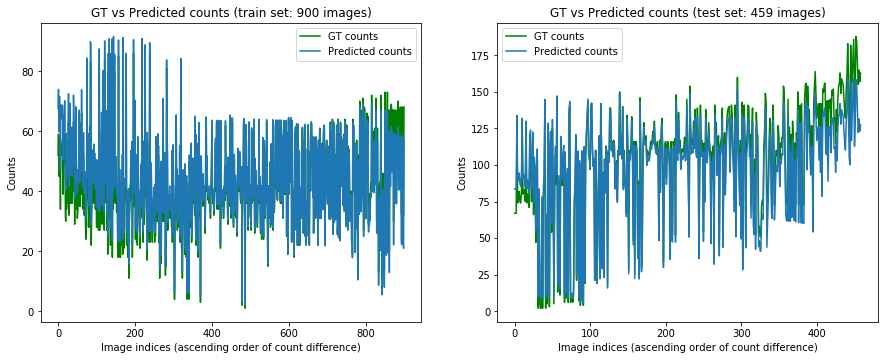

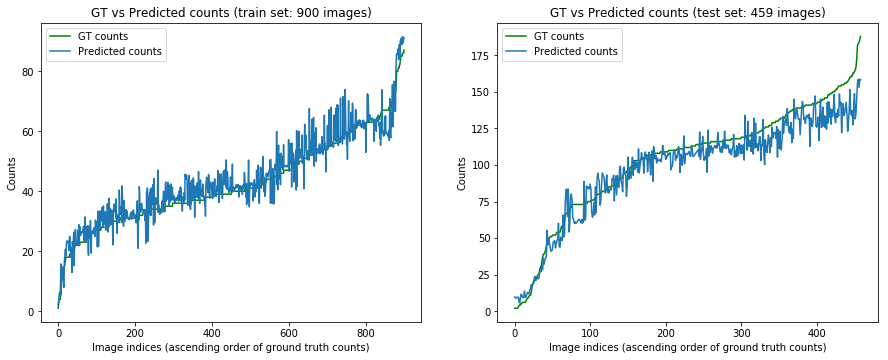

In [16]:
print(f'{config.DATASET_NAME} dataset')

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False,
                       criterion='gt', print_stats=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False,
                       criterion='gt', print_stats=False)

## 4.2 Predict and evaluate (density maps * (seg_maps > thr))

In [17]:
train_pred_counts = predict_density_maps_and_get_counts(model, train_generator,
                                                        config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                                        output_mode='seg_reg',
                                                        pred_seg_thr=config.PRED_SEG_THR)
val_pred_counts = predict_density_maps_and_get_counts(model, val_generator,
                                                      config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                                      output_mode='seg_reg',
                                                      pred_seg_thr=config.PRED_SEG_THR)
test_pred_counts = predict_density_maps_and_get_counts(model, test_generator,
                                                       config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                                       output_mode='seg_reg',
                                                       pred_seg_thr=config.PRED_SEG_THR)

In [18]:
train_results = evaluation_results_as_dict(train_gt_counts, train_pred_counts, 'train')
val_results = evaluation_results_as_dict(val_gt_counts, val_pred_counts, 'val')
test_results = evaluation_results_as_dict(test_gt_counts, test_pred_counts, 'test')

df = evaluation_results_as_df(train_results, val_results, test_results,
                              config.ARCHITECTURE_NAME,
                              config.SUB_EXPERIMENT_NAME,
                              config.DATASET_NAME)

df.to_csv(f'{QUANTITATIVE_RESULTS_PATH}/results_density_seg.csv', index=True)

df.head(3)

MAE  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split          
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train          3.199   
                                                                                  val            3.373   
                                                                                  test           8.656   

                                                                                                   RMSE  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split           
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train           4.341   
                                                                                  val             4.523   
                                                                                  test           10.907   

                                                                                                Underestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split                 
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train                1.851%   
                                                                                  val                  2.128%   
                                                                                  test                 7.101%   

                                                                                                Overestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split                
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train               5.670%   
                                                                                  val                 5.394%   
                                                                                  test                1.263%   

                                                                                                Difference  
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split             
SegRegNet         carpk/sigma_10_loss_logcosh_full_img_epochs_3_l... carpk        train             7.521%  
                                                                                  val               7.521%  
                                                                                  test              8.364%

## 5.2 Short analysis of evaluation results (density * (seg_map > thr))

carpk dataset

train set: 900 images
Underestimation in 235 images
Overestimation in 665 images
(GT stats)         counts per image: mean=42.54, std=14.82, min=1,    max=87
(Prediction stats) counts per image: mean=44.16, std=14.84, min=1.99, max=91.13

test set: 459 images
Underestimation in 354 images
Overestimation in 105 images
(GT stats)         counts per image: mean=103.48, std=39.14, min=2,    max=188
(Prediction stats) counts per image: mean=97.44, std=35.09, min=5.37, max=158.06


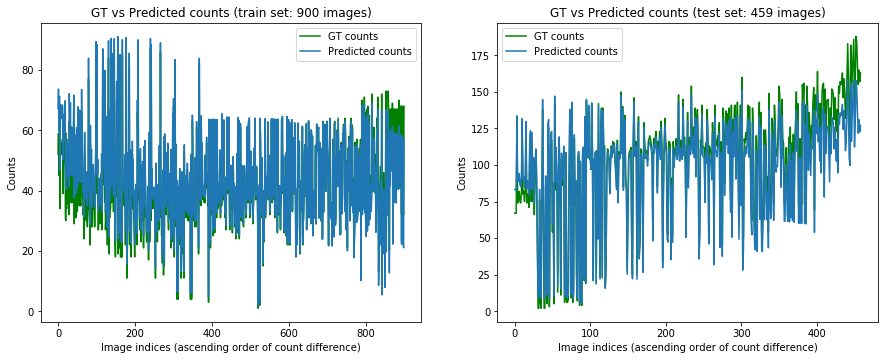

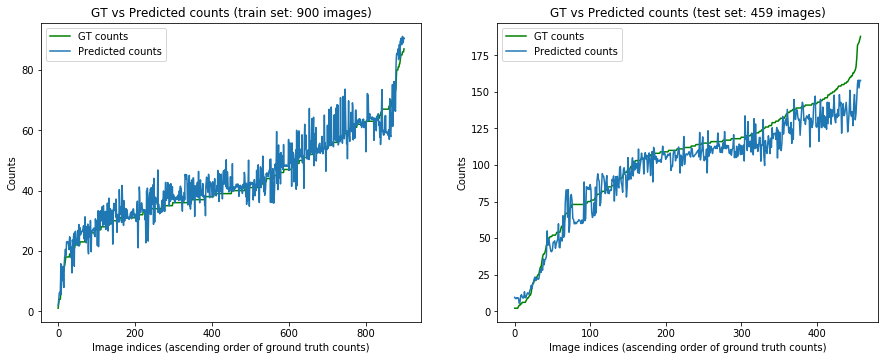

In [19]:
print(f'{config.DATASET_NAME} dataset')

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False,
                       criterion='gt', print_stats=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False,
                       criterion='gt', print_stats=False)

## 6. Look at some predictions (a small batch from the test set)

In [20]:
NUM_IMAGES = 3
test_images, gt_test_density_maps = load_images_and_density_maps(config.TEST_PATH, NUM_IMAGES)
gt_test_seg_maps = (np.asarray(gt_test_density_maps) > config.GT_SEG_THR)

pred_test_seg_maps, pred_test_density_maps = model.predict(np.array(test_images))
pred_test_density_maps /= config.DENSITY_MAP_MULTIPLICATION_FACTOR

def small_desc(images_batch, title):
    print(title)
    print(len(images_batch),
          images_batch[0].shape, images_batch[0].dtype,
          images_batch[0].min(), images_batch[0].max())
    print()
    
small_desc(test_images, 'test_images')
small_desc(gt_test_seg_maps, 'gt_test_seg_maps')
small_desc(pred_test_seg_maps, 'pred_test_seg_maps')
small_desc(gt_test_density_maps, 'gt_test_density_maps')
small_desc(pred_test_density_maps, 'pred_test_density_maps')

test_images
3 (720, 1280, 3) float64 0.0 1.0

gt_test_seg_maps
3 (720, 1280) bool False True

pred_test_seg_maps
3 (720, 1280, 1) float32 3.2338947e-11 1.0

gt_test_density_maps
3 (720, 1280) float64 0.0 0.0028073483693418734

pred_test_density_maps
3 (720, 1280, 1) float32 -0.00021124283 0.0017159822



before applying PRED_SEG_THR (density_map)


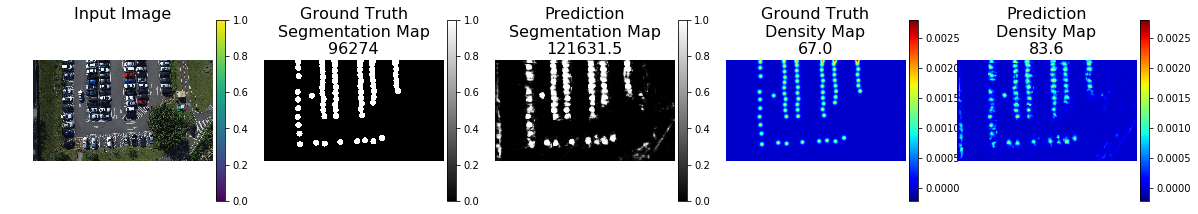

after applying PRED_SEG_THR (density_map * (seg_map > pred_seg_thr))
PRED_SEG_THR: 0.001


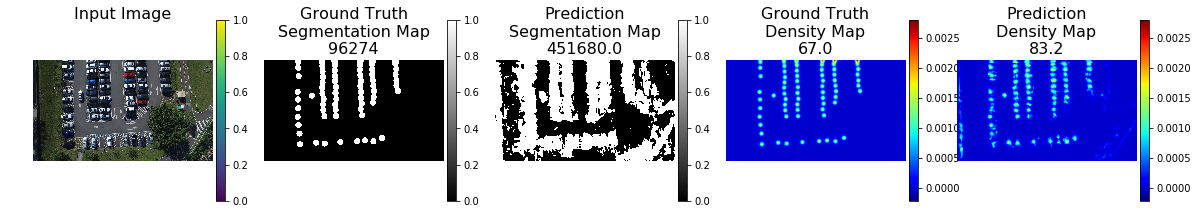

--------------------------------------------------------------------------
before applying PRED_SEG_THR (density_map)


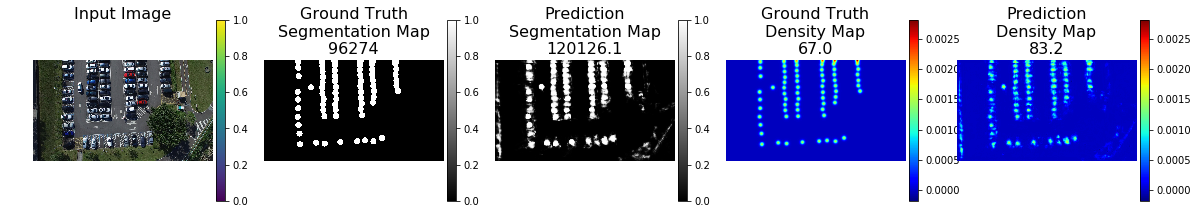

after applying PRED_SEG_THR (density_map * (seg_map > pred_seg_thr))
PRED_SEG_THR: 0.001


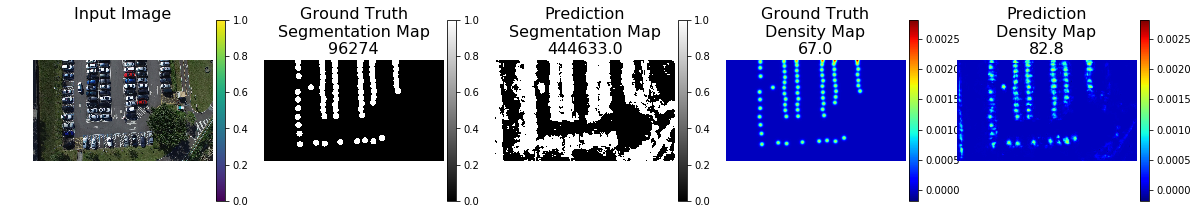

--------------------------------------------------------------------------
before applying PRED_SEG_THR (density_map)


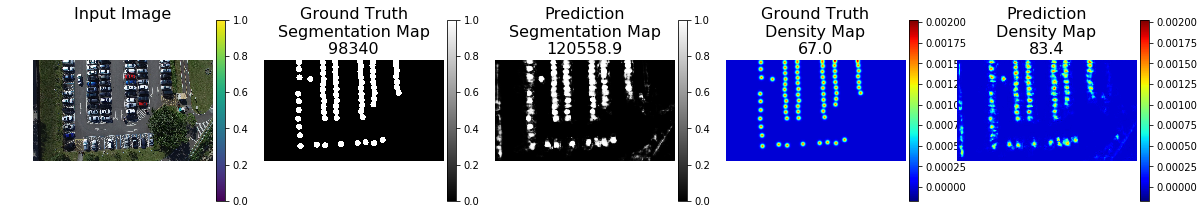

after applying PRED_SEG_THR (density_map * (seg_map > pred_seg_thr))
PRED_SEG_THR: 0.001


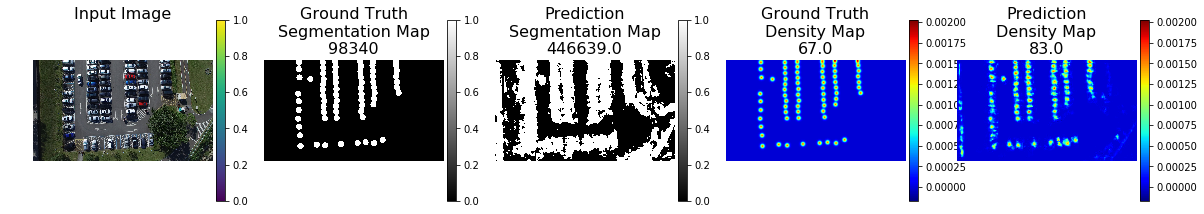

--------------------------------------------------------------------------


In [21]:
for i in range(3):
    print('before applying PRED_SEG_THR (density_map)')
    plot_seg_reg_maps(test_images[i], gt_test_seg_maps[i], pred_test_seg_maps[i],
                      gt_test_density_maps[i], pred_test_density_maps[i][np.newaxis], 1)

    print('after applying PRED_SEG_THR (density_map * (seg_map > pred_seg_thr))')
    print('PRED_SEG_THR:', config.PRED_SEG_THR)
    plot_seg_reg_maps(test_images[i], gt_test_seg_maps[i], pred_test_seg_maps[i]>config.PRED_SEG_THR,
                      gt_test_density_maps[i],
                      (pred_test_density_maps[i] * (pred_test_seg_maps[i]>config.PRED_SEG_THR))[np.newaxis], 1)
    
    print('--------------------------------------------------------------------------')